# Facial Recognition 

Example based on [sklearn documentation](http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html)

The dataset used in this example is a preprocessed excerpt of the
group [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/), aka LFW,
which has collected a set of face images, along with the names of the people in those images. 
The dataset contains a collection of 13,000 images of over a thousand people (mostly politicians).

Our classification task is going to be whose face is on each image. We will use `PCA` and `SVM` in this notebook.


Support vector machines or 'SVMs' are a set of supervised methods used for classification, regression and outliers detection. We will use it for classification here.  You can read more about SVMs here: 'http://scikit-learn.org/stable/modules/svm.html' and we will see them later in the semester. 


### Importing code and data

In [1]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import RandomizedPCA, PCA
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Gustavo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Gustavo\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def plot_gallery(images, titles=None, h=50, w=37, n_row=2, n_col=7):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks([]), plt.yticks([])
        if titles is not None:
            plt.title(titles[i], size=12)

**Nota bene** the function `fetch_lfw_people` downloads the dataset (~200MB) to your local drive. This can take a while.  It will only download the data once, and will read it from your local drive afterwards.

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

### Data exploration

Note that `lfw_people.images` and `lfw_people.data` are the same dataset, but stored differently. The `images` are stored as 50x37 pixels, whereas the `data` has all the pixels in a single row of 1850 bytes.

In [4]:
print (lfw_people.images.shape)
print (lfw_people.data.shape)

(1288, 50, 37)
(1288, 1850)


1288 images of 50x37 pixels (total of 1850 features) of 7 people:


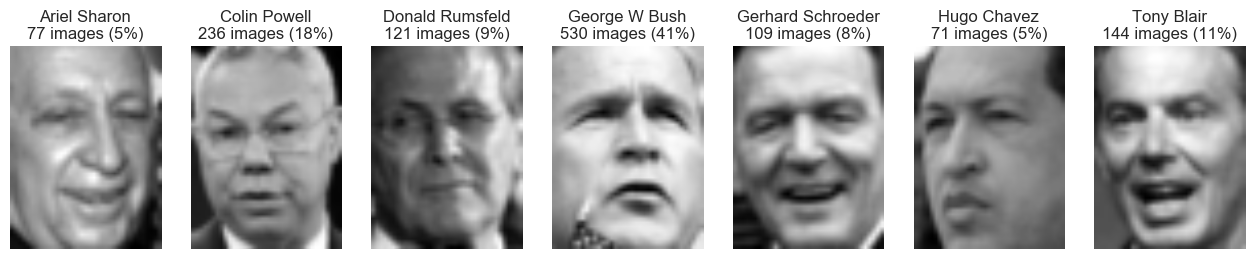

In [6]:
n_samples, height, width = lfw_people.images.shape
n_features = lfw_people.data.shape[1]

X = lfw_people.data
y = lfw_people.target  # the label to predict is the id of the person
target_names = lfw_people.target_names
y_names = np.array([target_names[i] for i in y])
n_classes = target_names.shape[0]

print ("%d images of %dx%d pixels (total of %d features) of %d people:" % (n_samples, height, width, n_features, n_classes))
    
uniques, idx, counts = np.unique(y, return_index=True, return_counts=True)
titles = ["%s\n%d images (%d%%)" % (name, count, 100 * count/n_samples) for name, count in zip(y_names[idx], counts)]
plot_gallery(X[idx], titles, height, width, n_row=1, n_col=n_classes)

Welcome back! Haven't we missed those faces! :)

### PCA

Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
dataset): this is unsupervised feature extraction, or dimensionality reduction. We bring the number of dimensions down from 1850 to a much smaller number. For PCA, it is important that all faces are centered, of the same size, and facing directly into the lense. 

`RandomizedPCA` is basically the same as `PCA`, but faster as it is a little less accurate in capturing all covariance. This loss in covariance is often just a matter of noise anyway, so that does not matter. 

If `whiten=True` (`False` by default) the `components_` vectors are divided by the singular values. Whitening will remove some information from the transformed signal (the relative variance scales of the components) but can sometime improve the predictive accuracy of the downstream estimators by making their data respect some hard-wired assumptions.

In [9]:
%%time
n_components = 150
print ("Split dataset into a training and testing set")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print ("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape(n_components, height, width)
print ("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Split dataset into a training and testing set
Extracting the top 150 eigenfaces from 966 faces


C:\Users\Gustavo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


Projecting the input data on the eigenfaces orthonormal basis
Wall time: 425 ms


Let's show how important these components are.

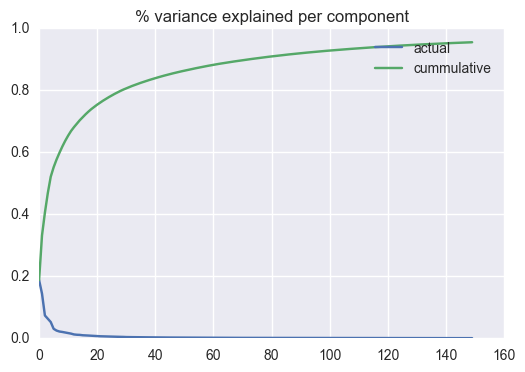

In [10]:
f = plt.plot(pca.explained_variance_ratio_, label="actual")
f = plt.plot(pca.explained_variance_ratio_.cumsum(), label="cummulative")
f = plt.title("% variance explained per component"), plt.legend()

It seems like you'd need only 30 coordinates to capture 80% of your data's variance. With 150 components, you'd capture 95% of your data.

### Most significative eigenfaces

Each component is in fact a face, sometimes called eigenfaces in the context of facial recognition. Your coordinates would tell you how heavy you'd like to weight that face in your total face. As we saw earlier, the first faces describe the most characteristics, while the later ones would explain mostly noise.

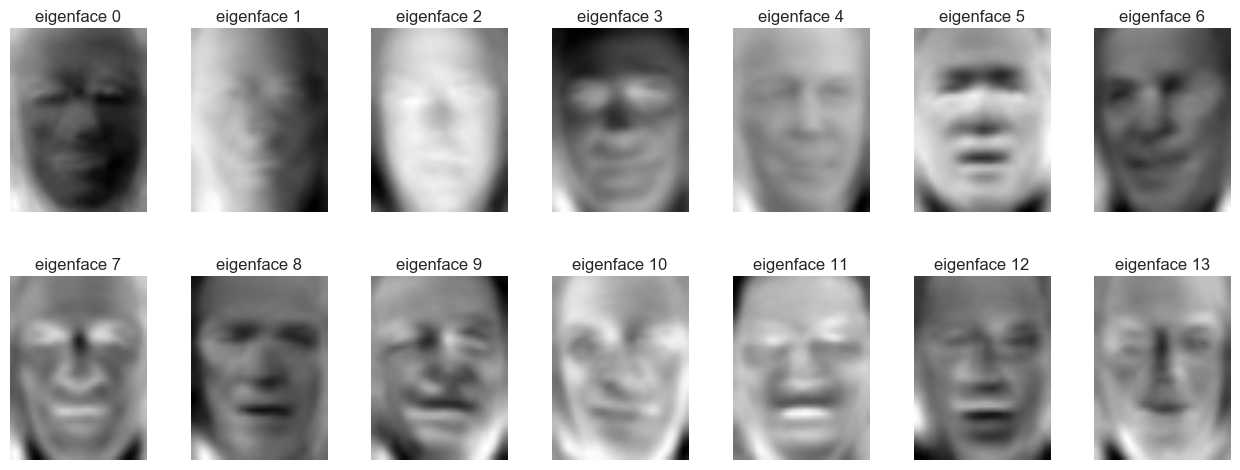

In [11]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, height, width)

### Reconstructing faces from mean face and eigenfaces components

Given these eigenfaces, we could reconstruct our original face if we would know all coordinates. In theory, we would need exactly 1850 coordinates, but since we captured only the most important components, we could describe our face pretty well only using 30 or 150 coordinates.

The face using zero components is the _mean face_, which is the average of all faces in our database.

Let's build W's face back. (You could run this cell multiple times, as it randomly picks a Bush from the set.)

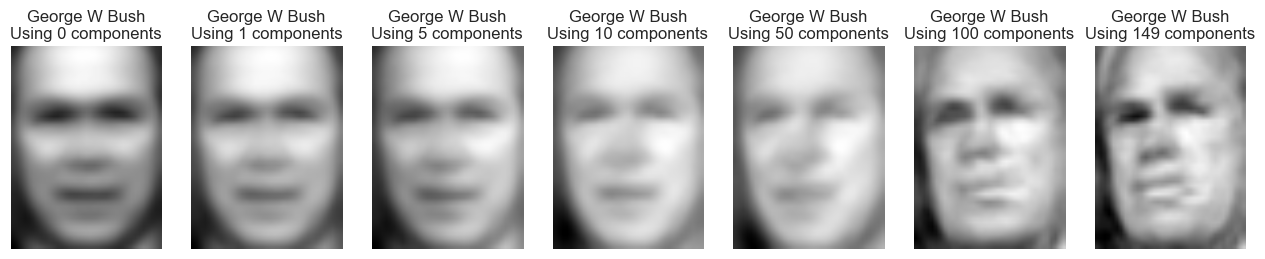

In [14]:
mean_face = pca.mean_.reshape(height, width)
show_components = [0, 1, 5, 10, 50, 100, 149]

components = pca.components_
if pca.whiten:  # If `whiten` was True, multiply components by their singular value
    components = np.array([pca.explained_variance_[i] * components[i] for i in range(n_components)])

no = np.random.choice(np.where(y_train == 3)[0])  # pick a random Bush
faces = np.array([X_train_pca[no][i] * components.reshape(n_components, height, width)[i] 
                  for i in range(n_components)]).cumsum(axis=0)
show_faces = [mean_face] + [mean_face + faces[k] for k in show_components]
titles = [target_names[y_train[no]] + "\nUsing %d components" % k for k in show_components]
plot_gallery(show_faces, titles, n_row=1)

### Facial Recognition

We train a SVM classification model to predict whose face we're looking at. Note that
- we use `GridSearchCV` to cross-validate our model against a grid of different parameters for `C` and `gamma`
- a lower `n_components` leads to much faster run times (but not necessarily less accuracy)
- `whiten=True` indeed leads to much higher accuracy

In [17]:
%%time
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
model = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
model = model.fit(X_train_pca, y_train)
print ("Best estimator found by grid search:", model.best_estimator_)

Best estimator found by grid search: SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Wall time: 17.8 s


Let's evaluate this 'best' model.

In [19]:
y_pred = model.predict(X_test_pca)
print ("Overall prediction accuracy:", model.score(X_test_pca, y_test))
print 
print (classification_report(y_test, y_pred, target_names=target_names))
print (confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Overall prediction accuracy: 0.860248447205
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.55      0.71        20
     Colin Powell       0.85      0.97      0.90        58
  Donald Rumsfeld       0.83      0.63      0.72        30
    George W Bush       0.84      0.97      0.90       136
Gerhard Schroeder       0.94      0.70      0.80        23
      Hugo Chavez       1.00      0.71      0.83        14
       Tony Blair       0.89      0.80      0.85        41

      avg / total       0.87      0.86      0.85       322

[[ 11   3   0   6   0   0   0]
 [  0  56   0   1   0   0   1]
 [  0   2  19   8   0   0   1]
 [  0   3   0 132   0   0   1]
 [  0   1   1   5  16   0   0]
 [  0   1   0   2   0  10   1]
 [  0   0   3   4   1   0  33]]


Not bad at all!

<hr>
## Exercises

- Play around with reconstructing the original faces. How many components would you generally need to recognize the face yourself? (A liberal estimate would suffice.)
- Which person is best classifiable? Who has been missclasified the most? Would you say the latter has a very common face?
- Play around with `n_components`, `whiten=True/False` to see different results of the facial recognition
- Use a few different models to see if you could improve your prediction accuracy.  Use `GridSearchCV` to seek the best model.  Candidates you migt want to try out are 
  - logistic regression, with different L1 or L2 regularization and varying values for `C`, and
  - a random forest (e.g., `RandonForestClassifier` or `GradientBoostingClassifier`) with varying amounts of trees.